In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np

from IPython import display

In [2]:
plt.ion()

In [3]:
env = gym.make("CartPole-v0").env

env.reset()
n_actions = env.action_space.n

# plt.imshow(env.render("rgb_array"))

In [4]:
# create agent
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(10, 10),
    activation='tanh',
    warm_start=True,  # keep progress between .fit(...) calls
    max_iter=2,  # make only 1 iteration on each .fit(...)
)

# initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()] * n_actions, range(n_actions))

/home/redcyb/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 10), learning_rate='constant',
              learning_rate_init=0.001, max_iter=2, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=True)

In [5]:
def generate_session(t_max=1000):

    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):

        # predict array of action probabilities
        probs = agent.predict_proba([s])[0]

        a = np.random.choice(n_actions, p=probs)

        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        
        if done:
            break
            
    return states, actions, total_reward

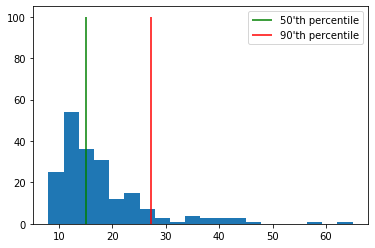

In [6]:
# let's see the initial reward distribution
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()

In [7]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """
    
    reward_threshold = np.percentile(rewards_batch, percentile)
    
#     elite_states = [s for idx, s in enumerate(states_batch) if rewards_batch[idx] >= reward_threshold]
#     elite_actions = [a for idx, a in enumerate(actions_batch) if rewards_batch[idx] >= reward_threshold]

    elite_mask = np.asarray(rewards_batch) >= reward_threshold
    elite_states = np.asarray(states_batch)[elite_mask]
    elite_actions = np.asarray(actions_batch)[elite_mask]

    return np.concatenate(elite_states), np.concatenate(elite_actions)

In [8]:
def update_policy(elite_states, elite_actions):
    """
    Given a list of elite states/actions from select_elites,
    return new updated policy where each action probability is proportional to

    policy[s_i,a_i] ~ #[occurences of si and ai in elite states/actions]

    Don't forget to normalize policy to get valid probabilities and handle 0/0 case.
    In case you never visited a state, set probabilities for all actions to 1./n_actions

    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions

    """

    new_policy = np.zeros([n_states, n_actions])
    
    for idx, s in enumerate(elite_states):
        new_policy[s, elite_actions[idx]] += 1.
        
    never_visited_mask = new_policy.sum(axis=1) == 0.
    new_policy[never_visited_mask] = 1.

    new_policy /= new_policy.sum(axis=1)[:, None]
    
    return new_policy

In [9]:
def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    display.clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

mean reward = 458.430, threshold=402.500


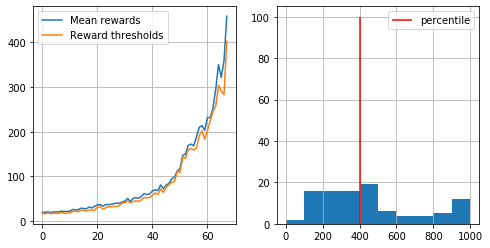

You Win! You may stop training now via KeyboardInterrupt.


In [10]:
n_sessions = 100
percentile = 50
log = []

for i in range(100):
    # generate new sessions
    sessions = [generate_session() for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

#     <fit agent to predict elite_actions(y) from elite_states(X)>
    agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")
        
    if np.mean(rewards_batch) > 400:
        break

In [11]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True)
sessions = [generate_session(10000) for _ in range(5)]
env.close()

In [12]:
# show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
     <video width="640" height="480" controls><source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[0]))  # this may or may not be _last_ video. Try other indices